# Multinomial logistic regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [3]:
from numpy.linalg import inv

## Useful utility functions

In [74]:
def one_hot_encode(labels):
    '''
    Convert label indices into one-hot vectors
    
    Args:
        labels: n-element array with label indices.
    
    Returns:
        n times k matrix where each row is a one-hot encoding
        of a class label. k - number of classes.
    '''
    one_hot = np.zeros(shape = (labels.shape[0], np.max(labels) + 1))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    
    return one_hot.astype(np.float32)

In [ ]:
np.reshape(W0[:-1, :].T, newshape=(2, -1, 28, 28))

In [5]:
def draw_params(ax, W):
    '''
    Draw parameters of a multinomial logistic regression in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        W:     Parameters of a multinomial logistic regression model.
               Shape (d+1) times k, where k is the number of classes and
               d is the number of explanatory variables.
    '''
    F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))
    tiles(ax, F)


def tiles(ax, M):
    '''
    Draw volume M in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        M:     Volume to plot. Shape: r times c times h times w, where
               r is the number of rows in the output plot,
               c is the number of columns in the output plot,
               h is the height of a single tile,
               w is the width of a single tile.
    '''
    rows_count = M.shape[0]
    cols_count = M.shape[1]
    tile_height = M.shape[2]
    tile_width = M.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(M[r, c])
            ex_max = np.max(M[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (M[r, c] - ex_min) / (ex_max - ex_min)
    
    ax.matshow(img_matrix, cmap='gray', interpolation='none')
    ax.axis('off')

## MNIST dataset

In this lab we will use [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/). Lets import and prepare this dataset.

In [6]:
# %pip install mnists

In [7]:
from mnists import MNIST
# https://github.com/pczarnik/mnists

mnist = MNIST()

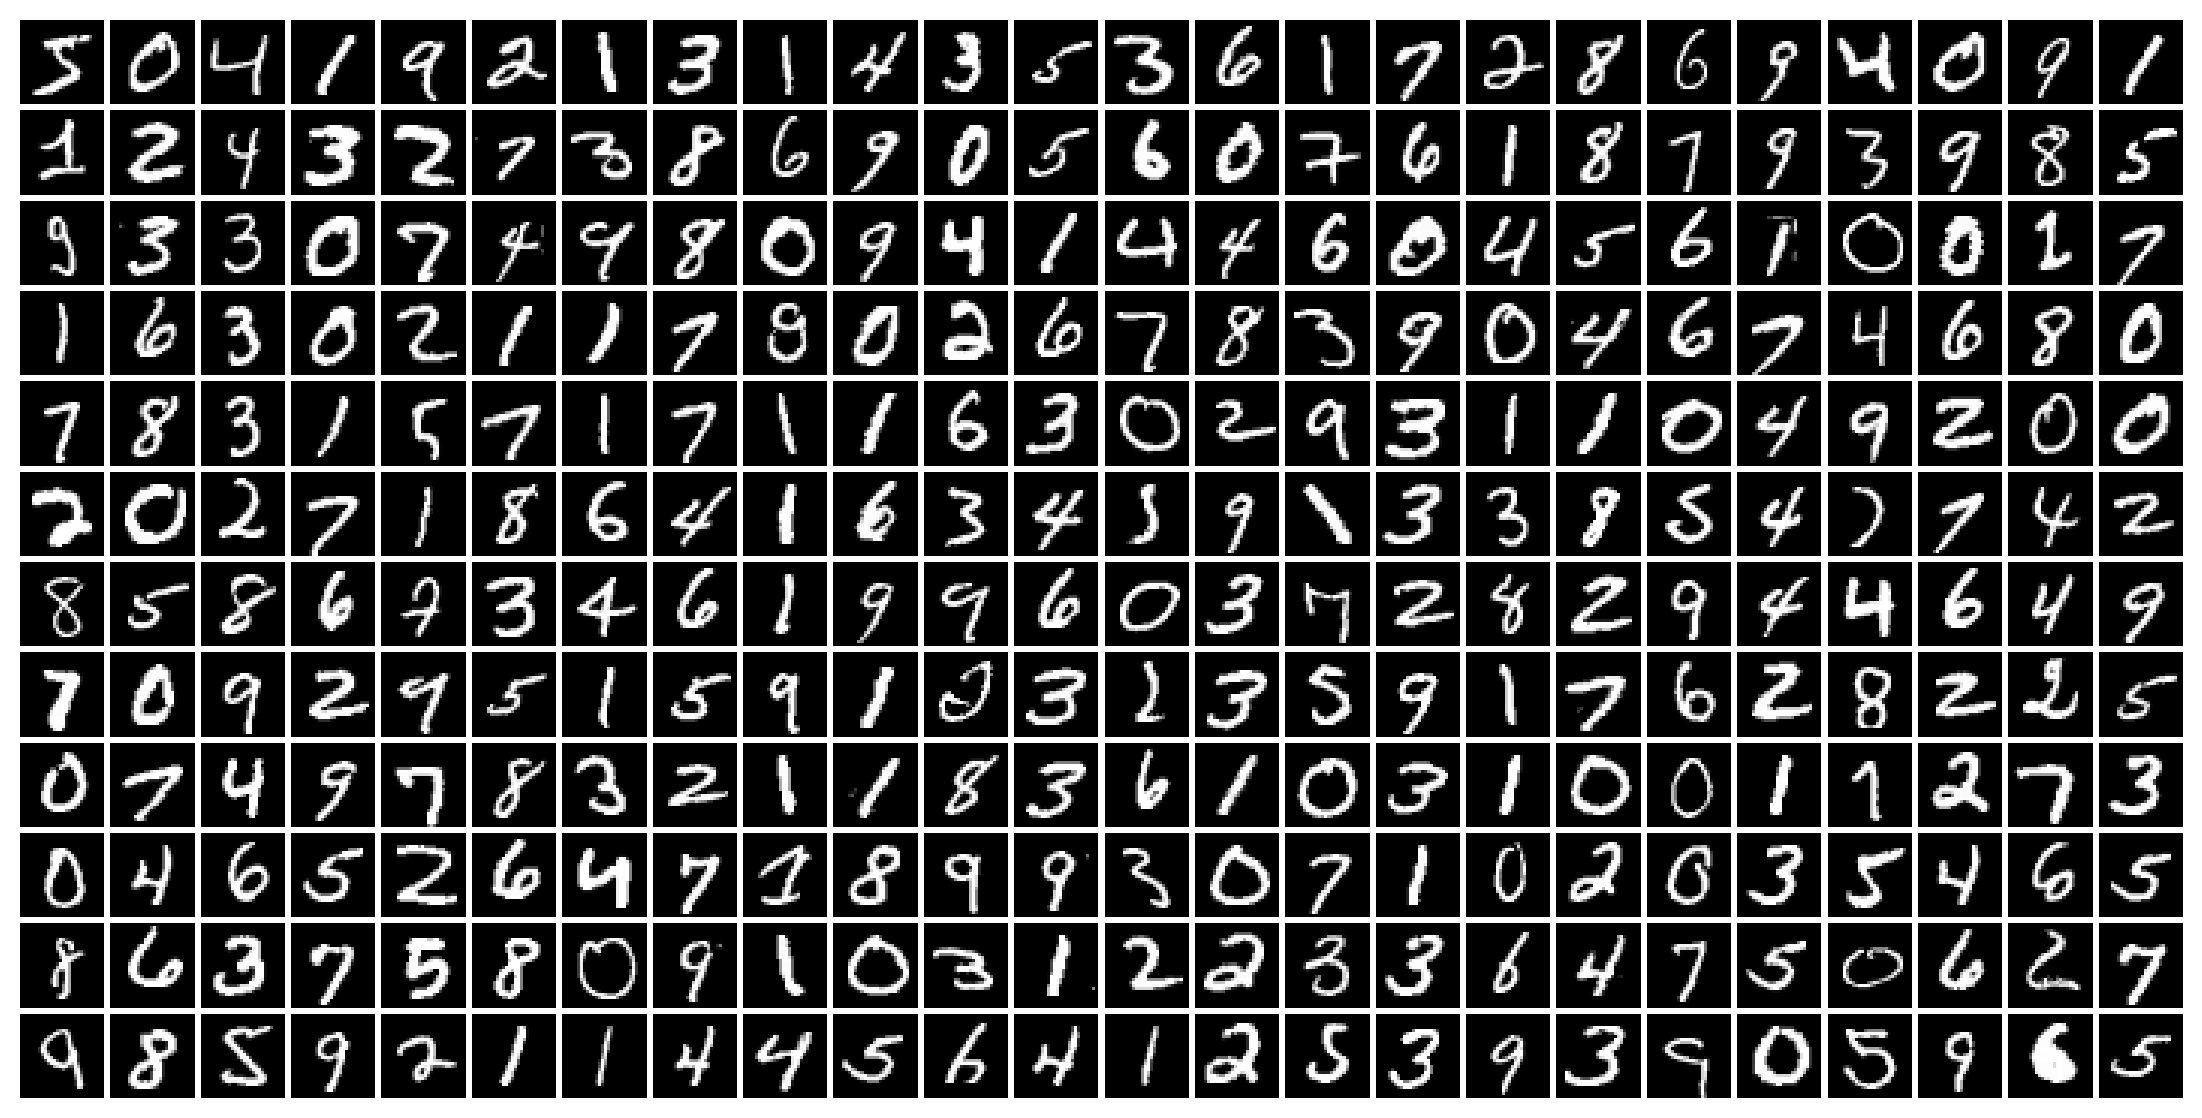

In [8]:
# import mnist

fig = plt.figure(figsize=(14, 7))
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(plt.gca(), digits)

We will reshape each $28 \times 28$ pixel image into a $1 \times 784$ vector and append a fixed $1$ at the end. We will also convert images from $255$ from 255255 gray levels to $\langle 0, 1 \rangle$ interval. Finally, we will pick a random subset of 20,000 examples for training. The test part of the MNIST dataset will be used for validation.

In [9]:
##### Train set #####

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_train_images.shape[0], 1))
mnist_train_images = np.concatenate((mnist_train_images, ones), axis=1)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Validation set #####

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_images = np.reshape(mnist_val_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_val_images.shape[0], 1))
mnist_val_images = np.concatenate((mnist_val_images, ones), axis=1)

mnist_val_labels = mnist.test_labels()
mnist_val_labels = one_hot_encode(mnist_val_labels)

## Multinomial logistic regression model

Our goal is to fit a multinomial logistic regression model to the MNIST dataset. We start by implementing the link function in this model.

### Softmax link function

Implement `softmax` function which takes an $n \times k$ matrix $\mathbf{Z}$ with class logits and returns an $n \times k$ matrix with categorical probability distributions for observations in $\mathbf{Z}$. The dimensions are: $n$ - number of observations, $k$ - number of classes.

---

**Implementation note**. Imagine that $z_{ij} = 100$. Then in a typical floating-point precision we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij}}}{\mathrm{e}^{z_{ij}} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{100}}{\mathrm{e}^{100} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{inf}}{\mathrm{inf}} = \mathrm{nan}
$$

However, note that for every finite $u \in \mathbb{R}$ we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{-u} \mathrm{e}^{z_{ij}}}{\mathrm{e}^{-u} \sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij} - u}}{\sum_{l=1}^k \mathrm{e}^{z_{il} - u}}
$$

So to implement `softmax` in a numerically stable manner, we can simply shift the logits (independently for each observation) so that: $\mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il} = 0$. That is, we set:

$$\large
z_{ij} \leftarrow z_{ij} - \mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il}
$$

This basically turns an overflow issue into an underflow that we can disregard. Use this trick when implementing `softmax` function.

In [91]:
def softmax(Z):
    # raise Exception('Implement softmax function')
    Z_max = np.max(Z, axis=1).reshape(-1, 1)
    Z = Z - Z_max
    Z_exp = np.exp(Z)
    Sum = np.sum(Z_exp, axis=1).reshape(-1, 1)
    return Z_exp / Sum

### Cost function

Next, we need to implement a cost function for our model and its gradient w.r.t the model parameters. Note that the cross-entropy cost increases proportionally to the number of input observations $n$. This is undesirable from an optimization point of view: the learning rate in gradient descent needs to be adjusted to the number of training observations. To avoid that issue we will calculate an <u>average</u> cross-entropy cost per input observation. That is, we will divide the cross-entropy cost (and therefore also its gradient) by $n$.

---

Implement `xentropy` function which takes as an input:
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for $n$ input observations.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for $n$ input observations.

and returns an average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$.



In [11]:
def xentropy(S, T):
    # raise Exception('Implement xentropy function')
    n = S.shape[0]
    return -1 * np.sum(T * np.log(S)) / n

Implement `grad_xentropy` function which takes as an input:
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for observations in $\mathbf{X}$.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for observations in $\mathbf{X}$.

and returns a gradient of the average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$. We assume a standard multinomial logistic regression parametrization:

\begin{align} \large
\mathbf{S}_{ij} & = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}, \\[1em]
\left[z_{ij}\right]_{n \times k} & = \mathbf{Z} = \mathbf{XW},
\end{align}

and return the gradient w.r.t the model parameters: $\mathbf{W}_{\left(d+1\right) \times k}$.

In [76]:
def grad_xentropy(X, S, T):
    # raise Exception('Implement grad_xentropy function')
    n = S.shape[0]
    return X.T @ (S - T) / n

### Gradient descent training

We are now ready to implement a maximum likelihood estimation for multinomial logistic regression model. We begin with few utility functions.

Implement `classify` function which takes as an input
- An $(d+1) \times k$ matrix $\mathbf{W}$ with parameters of a multinomial logistic regression model.
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.

and returns an $n \times k$ NumPy array with predicted class labels in one-hot encoding. We assume that the class predicted for a given observation is the one with the largest probability.

In [20]:
def classify(W, X):
    # raise Exception('Implement classify function')
    Z = X @ W # przekształcenie afiniczne i nasz logit
    S = softmax(Z)
    return (S == np.max(S, axis=1, keepdims=True)) * 1    

In [42]:
S = np.array(
    [
        [0.1, 0.05, 0.3, 0.35, 0.2],
        [0.05, 0.15, 0.3, 0.1, 0.4],
    ])

In [15]:
np.max(S, axis=0)

array([0.1 , 0.15, 0.3 , 0.35, 0.4 ])

In [19]:
(S == np.max(S, axis=1, keepdims=True)) * 1

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [17]:
(S == np.max(S, axis=1, keepdims=True)).astype("float")

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [21]:
(S == np.max(S, axis=1, keepdims=True)).astype("int")

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [48]:
P = (S == np.max(S, axis=1, keepdims=True)).astype("int")
P

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [49]:
T = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1]
])

In [50]:
P * T

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [51]:
np.sum(P * T)

1

In [53]:
def calc_acc(P, T):
    '''
    Calculate classification accuracy.
    
    Args:
        P: predicted labels in one-hot encoding,
           shape n times k.
        T: true labels in one-hot encoding,
           shape n times k.           
    
    Returns:
        Percentage of correctly predicted labels.
    '''
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    '''
    A utility function used to display the progress of gd_fit.
    '''
    log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t' \
          'validation accuracy: {:5.2f}'
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())
    
    print(log)


We will minimize the cost function with gradient descent. Complete the implementation of `gd_fit` function following comments in the code.

In [110]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the cost function and store it in `cost_val` variable.
        S = softmax(X @ W)
        cost_val = xentropy(S, T)
        
        
        # Next, calculate the gradient of the cost function w.r.t the parameters
        # in `W`. Use this gradient matrix to update `W` (according to the gradient
        # descent update rule).
        W = W - lr * grad_xentropy(X, S, T)      
        
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

## Fitting multinomial logistic regression model to MNIST.

Lets prepare and plot some initial parameter values.

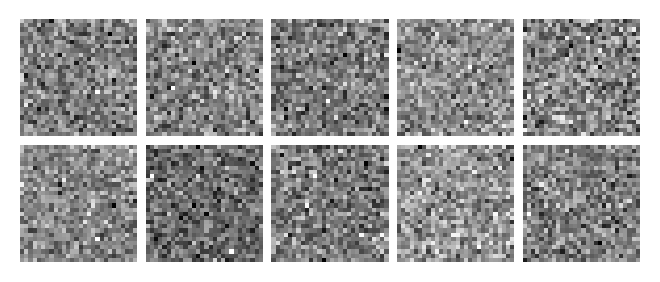

In [114]:
W0 = np.random.randn(DIGIT_SIZE*DIGIT_SIZE + 1, 10)

fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W0)

In [79]:
W0.shape

(785, 10)

We can now fit multinomial logistic regression model to the MNIST dataset. Initially we do 200 gradient descent steps starting from `W0`.

In [111]:
W = gd_fit(W0,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=3.0, steps=200, log_every=10)

Step   1	cost value: 12.78,	train accuracy: 21.97,	validation accuracy: 22.97
Step  10	cost value:  3.20,	train accuracy: 66.64,	validation accuracy: 67.39
Step  20	cost value:  1.56,	train accuracy: 75.44,	validation accuracy: 76.42
Step  30	cost value:  1.15,	train accuracy: 79.63,	validation accuracy: 80.59
Step  40	cost value:  1.00,	train accuracy: 81.47,	validation accuracy: 82.22
Step  50	cost value:  0.91,	train accuracy: 82.45,	validation accuracy: 83.32
Step  60	cost value:  0.85,	train accuracy: 83.20,	validation accuracy: 84.02
Step  70	cost value:  0.81,	train accuracy: 83.87,	validation accuracy: 84.50
Step  80	cost value:  0.76,	train accuracy: 84.56,	validation accuracy: 85.23
Step  90	cost value:  0.71,	train accuracy: 85.22,	validation accuracy: 85.68
Step 100	cost value:  0.68,	train accuracy: 85.65,	validation accuracy: 86.09
Step 110	cost value:  0.67,	train accuracy: 85.57,	validation accuracy: 85.97
Step 120	cost value:  0.68,	train accuracy: 85.30,	validation ac

Next, we continue with additional 300 steps using a lower learning rate.

In [112]:
W = gd_fit(W,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=0.3, steps=300, log_every=25)

Step   1	cost value:  0.50,	train accuracy: 89.09,	validation accuracy: 88.41
Step  25	cost value:  0.49,	train accuracy: 89.11,	validation accuracy: 88.43
Step  50	cost value:  0.49,	train accuracy: 89.08,	validation accuracy: 88.43
Step  75	cost value:  0.49,	train accuracy: 89.11,	validation accuracy: 88.45
Step 100	cost value:  0.49,	train accuracy: 89.18,	validation accuracy: 88.45
Step 125	cost value:  0.48,	train accuracy: 89.20,	validation accuracy: 88.50
Step 150	cost value:  0.48,	train accuracy: 89.22,	validation accuracy: 88.46
Step 175	cost value:  0.48,	train accuracy: 89.24,	validation accuracy: 88.45
Step 200	cost value:  0.48,	train accuracy: 89.25,	validation accuracy: 88.44
Step 225	cost value:  0.47,	train accuracy: 89.28,	validation accuracy: 88.43
Step 250	cost value:  0.47,	train accuracy: 89.30,	validation accuracy: 88.43
Step 275	cost value:  0.47,	train accuracy: 89.34,	validation accuracy: 88.43
Step 300	cost value:  0.47,	train accuracy: 89.37,	validation ac

Let's plot the fitted parameters.

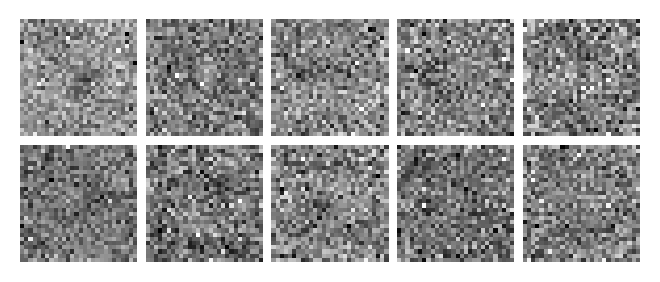

In [113]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W)

## Fitting regularized multinomial logistic regression model to MNIST.

Cross entropy cost function is convex but it is <u>not</u> strictly convex. We can turn it into a strictly convex cost function by adding a regularization term that penalizes magnitudes of model parameters:

$$ \large
\mathcal{L}_R\left(\mathbf{W}\right) = \mathcal{L}\left(\mathbf{W}\right) +
                                       \frac{\lambda}{2}\sum_{i=1}^{d+1}\sum_{j=1}^k w_{ij}^2,
$$

where $\mathcal{L}\left(\mathbf{W}\right)$ is the cross entropy cost.

This is the same regularization that we used in ridge regression, and it can be derived as a MAP estimate in a Bayesian logistic regression model with Gaussian prior on model parameters (we do not need a conjugate prior to find the cost function for a MAP estimate). Let's implement this variant of the logistic regression model.

Complete the implementation of `gd_fit_reg` function following comments in the code.

In [98]:
# W0, mnist_train_images, mnist_train_labels, mnist_val_images, mnist_val_labels

In [130]:
def gd_fit_reg(W0, X, T, X_val, T_val, l2=0.005, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        l2:        The regularization strength (\lambda hyper-paramater).
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the regularized cost function and store it in `cost_val` variable.
        S = softmax(X @ W)
        cost_val = xentropy(S, T)
        
        # Next, calculate the gradient of the regularized cost function w.r.t the
        # parameters in `W`. Use this gradient matrix to update `W` (according to
        # the gradient descent update rule).
        # W = W - lr * (grad_xentropy(X, S, T) - l2 * W)
        W = W - lr * (grad_xentropy(X, S, T) + l2 * W)
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

Let's fit regularized multinomial logistic regression model to the MNIST dataset.

In [131]:
W_reg = gd_fit_reg(W0,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=3.0,
                   steps=200, log_every=10)

Step   1	cost value: 12.89,	train accuracy: 21.91,	validation accuracy: 21.52
Step  10	cost value:  2.06,	train accuracy: 61.94,	validation accuracy: 61.81
Step  20	cost value:  2.26,	train accuracy: 68.87,	validation accuracy: 68.74
Step  30	cost value:  1.95,	train accuracy: 73.37,	validation accuracy: 73.22
Step  40	cost value:  1.53,	train accuracy: 73.59,	validation accuracy: 72.89
Step  50	cost value:  1.36,	train accuracy: 75.11,	validation accuracy: 74.97
Step  60	cost value:  1.14,	train accuracy: 76.05,	validation accuracy: 76.03
Step  70	cost value:  1.51,	train accuracy: 70.91,	validation accuracy: 70.17
Step  80	cost value:  1.34,	train accuracy: 78.80,	validation accuracy: 79.32
Step  90	cost value:  0.77,	train accuracy: 80.01,	validation accuracy: 79.96
Step 100	cost value:  1.52,	train accuracy: 75.87,	validation accuracy: 76.04
Step 110	cost value:  1.24,	train accuracy: 75.20,	validation accuracy: 75.18
Step 120	cost value:  1.54,	train accuracy: 74.08,	validation ac

In [132]:
W_reg = gd_fit_reg(W_reg,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=0.3,
                   steps=300, log_every=25)

Step   1	cost value:  1.01,	train accuracy: 81.40,	validation accuracy: 82.21
Step  25	cost value:  0.39,	train accuracy: 89.59,	validation accuracy: 90.14
Step  50	cost value:  0.37,	train accuracy: 89.84,	validation accuracy: 90.42
Step  75	cost value:  0.35,	train accuracy: 90.11,	validation accuracy: 90.60
Step 100	cost value:  0.34,	train accuracy: 90.35,	validation accuracy: 90.74
Step 125	cost value:  0.33,	train accuracy: 90.54,	validation accuracy: 90.87
Step 150	cost value:  0.33,	train accuracy: 90.71,	validation accuracy: 90.90
Step 175	cost value:  0.32,	train accuracy: 90.83,	validation accuracy: 90.92
Step 200	cost value:  0.32,	train accuracy: 90.95,	validation accuracy: 91.03
Step 225	cost value:  0.32,	train accuracy: 91.07,	validation accuracy: 91.15
Step 250	cost value:  0.32,	train accuracy: 91.17,	validation accuracy: 91.20
Step 275	cost value:  0.32,	train accuracy: 91.22,	validation accuracy: 91.21
Step 300	cost value:  0.32,	train accuracy: 91.29,	validation ac

Finally we plot the parameters of the regularized model.

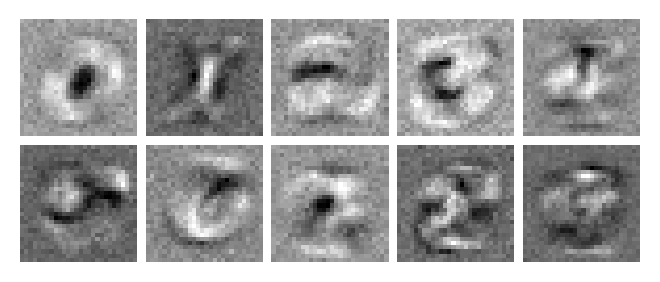

In [133]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W_reg)